# Recommender Systems - LSTM

The following script attempts to predict whether a user will be interested in a scientific article or not by using LSTM neural network.
To do this the CiteULike dataset is used. the dataset contains the previous interactions between users and other scientific artiles. Using embeddings for users and items a prediction can be done. 
The following LSTM model uses the article titles.

The following code borrows heavily from the following websites

https://github.com/munkai/pytorch-tutorial/blob/master/2_intermediate/4.1-Sequences.ipynb

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

https://www.mathworks.com/matlabcentral/answers/418986-how-to-calculate-true-positive-true-negative-false-positive-and-false-negative-as-we-have-segment

https://github.com/pytorch/text

http://anie.me/On-Torchtext/

https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84?fbclid=IwAR0cV9dnv4P5snK_SONbKUJ7lP4dlw1lAifju2OwS-gJ6aaKgarXuIDatuk

https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84?fbclid=IwAR0EyyeiCQMUtThSBMqhmI1ObQiuExKmbKM1g_kk7MfykENDVY4BEzB3v-4

https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/3_Recurrent/3.1-Sequencial-Data.ipynb

In [1]:
#!pip install torchtext
#!pip install torch

In [2]:
#### Packages ####
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab
import pandas as pd
import numpy as np
import spacy
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
from pprint import pprint
import torch.nn.utils.rnn as rnn_utils

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from random import shuffle
from torch.nn import Linear
from torch.nn.functional import softmax, relu
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab

#### Dataloader
We create a dataloader in order to split the dataset to a training, validation and test dataset. 

In [3]:
#### Read datasets #### 
CiteULike_data=pd.read_csv('raw-data.csv')

#### Loading small dataset for speed ####
User_info = pd.read_csv('user-info-small.csv')

#### Create function for index moving ####
def zero_indexing(nparr):
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr]), uniq

#### Move index, shuffle ####
User_info["user.id"], uniq = zero_indexing(User_info["user.id"].values)
User_info = User_info.sample(frac=1) # Shuffle

#### Replace doc.id with title of article ####
User_info["doc.id"] = [CiteULike_data.iloc[int(idx),1] for idx in User_info["doc.id"]]

#### Find the maximum sequence length for titles ####
max_length = max((len(s.split(' ')) for s in CiteULike_data.iloc[:,1]))
print("maximum sequence length of titles:")
print(max_length)


#### Split train, validation and test in respectively 70%,20% and 10% of the data size ####
n=len(User_info)
trn_len=int(n*0.7)
val_len=int(n*0.2)
test_len=n-trn_len-val_len

train = User_info[:trn_len]
val = User_info[trn_len:-test_len]
test = User_info[trn_len:-val_len]


maximum sequence length of titles:
33


In [4]:
#### Printing example of dataset ####
CiteULike_data.head()

,doc.id,title,citeulike.id,raw.title,raw.abstract
0,1,the metabolic world of escherichia coli is not...,42,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...
1,2,reverse engineering of biological complexity,43,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...
2,3,exploring complex networks,44,Exploring complex networks,"The study of networks pervades all of science,..."
3,4,comparative assessment of largescale data sets...,46,Comparative assessment of large-scale data set...,Comprehensive protein protein interaction maps...
4,5,navigation in a small world,47,Navigation in a small world,The small-world phenomenon — the principle tha...


In [5]:
#### For Training Dataset ####
#### Defining unique coloumns and userId and removing the header #### 
uniq_items = np.unique(CiteULike_data["doc.id"])[:-1]
uniq_users = np.unique(train["user.id"])[:-1]
items = set((x[0],x[1]) for x in train[["user.id","doc.id"]].values)

#### Find pairs of users and items which have no interaction and create negative samples for them #### 
pairs = []
i = 0
while(i < len(train)):
    
    item = np.random.choice(uniq_items, size = 1)[0]
    user = np.random.choice(uniq_users, size = 1)[0]
    if (user,item) not in items:
        i += 1
        pairs += [(user,item,0)]
        items.add((user,item))

User_info_Negatives = np.vstack((train, pairs))

#### Create datasets and save these for later
train = pd.DataFrame(data = User_info_Negatives,columns = ["user.id","doc.id", "rating"])
test.to_csv('test.csv', header = False, index = False)

#### Cleanup of memory
del User_info_Negatives, items, uniq_items, uniq_users, pairs, User_info, test

for i, idx in enumerate(train["doc.id"][trn_len:]):
    train["doc.id"].loc[trn_len+i] = CiteULike_data.iloc[int(idx),1]

train = train.sample(frac = 1)

train.to_csv('train.csv', header = False, index = False)


In [6]:
#### For Validation Dataset ####
#### Defining unique coloumns and userId and removing the header #### 
uniq_items = np.unique(CiteULike_data["doc.id"])[:-1]
uniq_users = np.unique(val["user.id"])[:-1]
items = set((x[0],x[1]) for x in val[["user.id","doc.id"]].values)

#### Find pairs in the data. Create negative samples from the missing obsevation (no interaction) ####
pairs = []
i = 0
while(i < len(val)):
    
    item = np.random.choice(uniq_items, size = 1)[0]
    user = np.random.choice(uniq_users, size = 1)[0]
    if (user,item) not in items:
        i += 1
        pairs += [(user,item,0)]
        items.add((user,item))

User_info_Negatives = np.vstack((val, pairs))

#### Create datasets and save these for later
val = pd.DataFrame(data = User_info_Negatives,columns = ["user.id","doc.id", "rating"])

#### Cleanup of memory
del User_info_Negatives, items, uniq_items, uniq_users, pairs

for i, idx in enumerate(val["doc.id"][val_len:]):
    val["doc.id"].loc[val_len+i] = CiteULike_data.iloc[int(idx),1]

val = val.sample(frac = 1)

val.to_csv('val.csv', header = False, index = False)

#### Tokenization
ID is the User_ID, TEXT is the article's title and LABEL is the rating 

TEXT is sequential data while LABEL and ID is not. 
Setting Text data to lower case and setting the fixed length to the maximum length so all examples will be padded according to this.

For Label and ID we set use_vocab=False because it is numerical. 
include_lengths – Whether to return a tuple of a padded minibatch and a list containing the lengths of each examples, or just a padded minibatch. Default: False.

reference: 
https://torchtext.readthedocs.io/en/latest/data.html#field

In [7]:
#### Load spaCy to tokenize text ####
spacy_en = spacy.load('en')

#### Define a tokenizer function ####
def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

#### Define the three datatypes in the data ####
TEXT = Field(sequential=True, lower=True, include_lengths=True, fix_length=None)
LABEL = Field(sequential=False, use_vocab=False)
ID = Field(sequential=False, use_vocab=False)

train, val, test = TabularDataset.splits(
        path='', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('ID', ID), ('Text', TEXT), ('Label', LABEL)])

print('Content of first training sample:')
pprint(vars(train[0]))

#### Create vocabulary using pretrained embeddings from GloVe ####
TEXT.build_vocab(train, vectors="glove.6B.100d")
LABEL.build_vocab(train)   #contains nothing (None) -since it contains no text
ID.build_vocab(train)      #contains nothing (None) -since it contains no text

Content of first training sample:
{'ID': '35', 'Label': '0', 'Text': ['asset', 'pricing']}


In [8]:
#### TEXT and LABEL ####
print('Text fields:')
print(' size of vocabulary:', len(TEXT.vocab))
print(" vocabulary's embedding dimension:", TEXT.vocab.vectors.size())
print(' no. times the "fun" appear in the dataset:', TEXT.vocab.freqs['fun'])

print('\nLabel fields:')
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))

Text fields:
 size of vocabulary: 5021
 vocabulary's embedding dimension: torch.Size([5021, 100])
 no. times the "fun" appear in the dataset: 1

Label fields:
 list of vocabulary (int-to-str): ['<unk>', '0', '1']
 list of vocabulary (str-to-int): {'<unk>': 0, '0': 1, '1': 2}


#### Data iterator
Choosing batchsize and defining the three iterators (one for train, validation and test).
We use sort_within_batch = True to group titles with almost the sequence lengths together in one batch and sort the sequence lengths of the titles in descreasing order for each batch.

In [9]:
#### Define batchsizes and create dataset splits ####
batch_size = (45, 45, 45)

#### Remebering to sort the text for speed ####
train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, val, test), batch_sizes=batch_size, sort_key=lambda x: len(x.Text), sort_within_batch = True)

In [10]:
#### Batch Information ####
batch = next(iter(train_iter))
print(batch)


[torchtext.data.batch.Batch of size 45]
	[.ID]:[torch.LongTensor of size 45]
	[.Text]:('[torch.LongTensor of size 14x45]', '[torch.LongTensor of size 45]')
	[.Label]:[torch.LongTensor of size 45]


### LSTM  - Building the model


In [11]:
#### Embedding sizes ####
TEXT_Shape = TEXT.vocab.vectors.size()  #[vocab_size,100]
print("text shape:")
print(TEXT_Shape)

num_embeddings = TEXT.vocab.vectors.size()[0]   # (vocabulary size)
print("num_embeddings:")
print(num_embeddings)

embedding_dim = TEXT.vocab.vectors.size()[1]   #100 (elements in each vector for each vocab)
print("embedding_dim:")
print(embedding_dim)

num_classes = len(LABEL.vocab.itos)   #[unkown,0,1]
print("num_classes:")
print(num_classes)

num_items = TEXT.vocab.vectors.size()[0]   #(vocabulary size)
print("num_items:")
print(num_items)

num_users = len(ID.vocab.itos)  # unique users in the train dataset
print("num_users:")
print(num_users)

n_hidden = 100
l1_hidden = 110
attention_size = 100

text shape:
torch.Size([5021, 100])
num_embeddings:
5021
embedding_dim:
100
num_classes:
3
num_items:
5021
num_users:
51


In [12]:
#### The LSTM Model with attention ####

class LSTM(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=embedding_dim, n_hidden=n_hidden, l1_hidden=l1_hidden):
        super(LSTM, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        
         # use pretrained embeddings
        self.item_emb.weight.data.copy_(TEXT.vocab.vectors)
        self.item_emb.weight.detach_()
        
        # Linear layers
        self.l_1 = nn.Linear(in_features = embedding_dim+n_hidden, 
                              out_features = l1_hidden)
        self.l_2 = nn.Linear(in_features = l1_hidden,
                              out_features = 1)
        
        # Dropout layers
        self.drop0 = nn.Dropout(p = 0.4)
        self.drop1 = nn.Dropout(p = 0.5)
                
        # RNN decoding
        self.rnn = nn.LSTM(embedding_dim, n_hidden, batch_first = False)
        
        self.sigmoid = nn.Sigmoid()
        
        ###### ATTENTION ######
        
        self.l1_att=nn.Linear(n_hidden, attention_size)
        #self.linU1=nn.Linear(n_hidden,attention_size)
        self.l2_att=nn.Linear(attention_size,1)
        self.softmax = nn.Softmax()
        
    def forward(self, u, v, hidden,seq_lengths):
      
        # Get embeddings
        U = self.user_emb(u) #[45,100]
        V = self.item_emb(v) #[33,45,100]

        # Pack the batch for performance
        packed = rnn_utils.pack_padded_sequence(V,seq_lengths)
        
        # Feed into LSTM
        LSTMOut, (hn, cn) = self.rnn(packed)
                
        # Unpack the result
        unpacked, seq_lengths = rnn_utils.pad_packed_sequence(LSTMOut, padding_value=-1e-200, total_length=max_length,batch_first=True)
        
        
        ###---------------------- Vanilla attention----------------------------###       
        # Steps in attention:
        # Take the LSTM output which has a dimension (len, n_hidden), each column in this output represents a location in the Title sequence.
        # The LSTM output is put through a nn.Linear function
        # It is then put through a tanh-function which gives the dimension (len, attention_size)
        # Again through a linear function
        # Then through a softmax and the dimension is updated to dim(len,1) --> called the alpha weights (sould sum to 1)
        # We then take the alpha weights and the output from LSTM and calculate: ((1/len)*sum_i(alpha_i * LSTMout_i))
        ## Packing, Encoding, Padding
        
        # linear layer
        V = self.l1_att(unpacked)
        #userx1 = self.linU1(U).unsqueeze(1)
        #x2 = torch.tanh(itemx1+userx1)
        
        V = torch.tanh(V)
        V = self.l2_att(V)
        
        # Attention weights
        alpha = self.softmax(V)
        # Check that sum(alpha)=1
        # print("alpha:")
        # print(alpha.sum(0))
        
        # Attention scores
        score= ((unpacked*alpha).transpose(1,2)).transpose(0,2)/seq_lengths.float()
        score = torch.sum(score,dim=0).transpose(0,1)
        
        # Concatinate the LSTM output and the user embedding
        output = torch.cat([score,U],dim=1)
       
        # Feed into NN 
        output = self.drop0(output)
        output = F.relu(self.l_1(output))
        output = self.drop1(output)
        output = self.l_2(output)
        
        output = self.sigmoid(output)
        return output
    
    def initialize_hidden(self, batch_size):
        init = torch.zeros(1, batch_size, n_hidden)
        return (init,init)

In [13]:
#### Training ####
def training(model, train_iter, optimizer, criterion, epoch):
    model.train() # built-in function
    # Initialize lists
    trainingacc_list = []
    trainingloss_list = []
    
    for index, (data,_) in enumerate(train_iter):
        users,(items, seq_lengths), ratings = data
        batch_size = len(items) #current batch size
        users = users.long()
        items = items.long()
        ratings = ratings.float()      
        
        # Optimization
        optimizer.zero_grad()
        hidden_size = model.initialize_hidden(batch_size)
        output = model(users, items, hidden_size, seq_lengths)
        
        training_loss = criterion(output, ratings) # BCE
        training_loss.backward() #back propagating
        optimizer.step()
        
        # Accuracy = (TP + TN)/(TP+TN+FP+FN)
        TP = FP = TN = FN = 0
        
        binaryreset = [0 if x < 0.5 else 1 for x in output.data]
        
        # Counting TP, TN, FP, FN based on the original value and our model's prediction
        for actual_rating, prediction in zip(ratings.data, binaryreset):
            if prediction == 1:
                if actual_rating != prediction:
                    FP += 1
                else:
                    TP += 1
            else:
                if actual_rating != prediction:
                    FN += 1
                else:
                    TN += 1
                    
        # Populating the lists
        trainingacc_list += [(TP + TN)/(TP + FP + TN + FN)]
        trainingloss_list += [training_loss.item()]
        
        # Averaging training accuracy and training loss
        train_accuracy = sum(trainingacc_list)/len(trainingacc_list)
        train_loss = sum(trainingloss_list)/len(trainingloss_list)
       
    return train_accuracy, train_loss

#### Validation ####
def validate(model, val_loader, criterion, epoch):
    # evaluation, built-in function
    model.eval()

    # Initializing
    valacc_list = []
    valloss_list = []
    TP = FP = TN = FN = 0
    
    with torch.no_grad():
        for index, (data, _) in enumerate(val_iter):
            users, (items, seq_lengths), ratings = data
            batch_size = len(items)
            users = users.long()
            items = items.long()
            ratings = ratings.float()
            
            hidden_size = model.initialize_hidden(batch_size)
            output = model(users, items, hidden_size, seq_lengths)
            validation_loss = criterion(output.float(), ratings) # comparing output to actual rating
            
            binaryreset = [0 if x < 0.5 else 1 for x in output.data]
            
            # Counting TP, TN, FP, FN based on the original value and our model's prediction
            for original_value, prediction in zip(ratings.data, binaryreset):
                if prediction == 1:
                    if original_value != prediction:
                        FP += 1
                    else:
                        TP += 1
                else:
                    if original_value != prediction:
                        FN += 1
                    else:
                        TN += 1
            
        # Populating the lists
        valacc_list += [(TP + TN)/(TP + FP + TN + FN)]
        valloss_list += [validation_loss.item()]
        
        # Averaging the validation accuracy and validation loss
        val_accuracy = sum(valacc_list)/len(valacc_list)
        val_loss = sum(valloss_list)/len(valloss_list)
       
    return val_accuracy, val_loss

#### Training over the given epochs ####
def trainLoop(epochs, lr = 0.001, wd = 1e-6):
    # Define model    
    model = LSTM(num_users, num_items)
    criterion = nn.BCELoss() # Binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd) # Adam optimizer
    
    # Initializing lists
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, epochs + 1):
        # Return results of loss and accuracy
        # Calling the models
        train_accuracy, train_loss = training(model, train_iter, optimizer, criterion, epoch)
        val_accuracy, val_loss = validate(model, val_iter, criterion, epoch)
        
        # Populating lists
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        val_accuracies += [val_accuracy]
        val_losses += [val_loss]
    
        print(f' Epoch {epoch}: Training loss: {train_loss:2.5f} | Training acc: {train_accuracy:2.5f} | Validation loss: {val_loss:2.5f} | Validiation acc: {val_accuracy:2.5f}')
    
    #### Plots #### 
    plt.plot(range(1, epoch + 1), train_accuracies)
    plt.plot(range(1, epoch + 1), val_accuracies)
    plt.xlabel('Epochs'), plt.ylabel('Accuracy')
    plt.legend(['Training accuracy','Validation accuracy'], loc = 1)
    plt.show()
    
    plt.plot(range(1,epoch+1),train_losses)
    plt.plot(range(1,epoch+1),val_losses)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend(['Training loss','Validation loss'], loc = 1)
    plt.show()


 Epoch 1: Training loss: 0.69064 | Training acc: 0.52869 | Validation loss: 0.67172 | Validiation acc: 0.56323
 Epoch 2: Training loss: 0.66017 | Training acc: 0.57430 | Validation loss: 0.65133 | Validiation acc: 0.62998
 Epoch 3: Training loss: 0.64877 | Training acc: 0.60730 | Validation loss: 0.63541 | Validiation acc: 0.65105
 Epoch 4: Training loss: 0.63494 | Training acc: 0.62322 | Validation loss: 0.62254 | Validiation acc: 0.65105
 Epoch 5: Training loss: 0.62593 | Training acc: 0.63250 | Validation loss: 0.61308 | Validiation acc: 0.67096
 Epoch 6: Training loss: 0.61764 | Training acc: 0.63947 | Validation loss: 0.60648 | Validiation acc: 0.67213
 Epoch 7: Training loss: 0.61258 | Training acc: 0.65224 | Validation loss: 0.59857 | Validiation acc: 0.66745
 Epoch 8: Training loss: 0.61455 | Training acc: 0.64179 | Validation loss: 0.59147 | Validiation acc: 0.66745
 Epoch 9: Training loss: 0.60297 | Training acc: 0.65655 | Validation loss: 0.58775 | Validiation acc: 0.66745
 

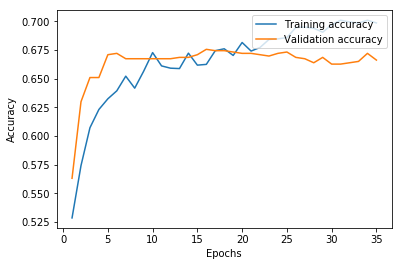

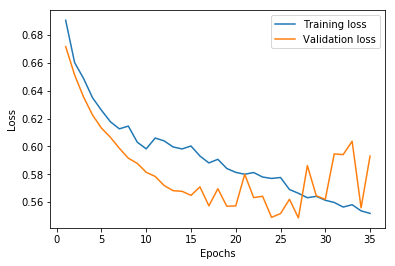

In [14]:
#### All Systems Go! ####
trainLoop(epochs = 35, lr = 0.0001, wd = 1e-6)